# Titanic: Machine Learning from Disaster

[Competition Link on Kaggle](https://www.kaggle.com/c/titanic)

In [27]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.model_selection import GridSearchCV , KFold
from sklearn.preprocessing import StandardScaler
from sklearn import svm


In [2]:
import pandas as pd
import numpy as np 
import seaborn as sns
from scipy.stats import norm
from scipy  import stats
# import matplotlib as plt
import matplotlib.pyplot as plt


plt.style.use('seaborn-ticks')
# print(plt.style.available)

In [3]:
data_test = pd.read_csv('datasets/titanic/test.csv')
data_train = pd.read_csv('datasets/titanic/train.csv')

In [4]:
data_test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [5]:
data_test.shape

(418, 11)

In [6]:
data_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [7]:
data_train.shape

(891, 12)

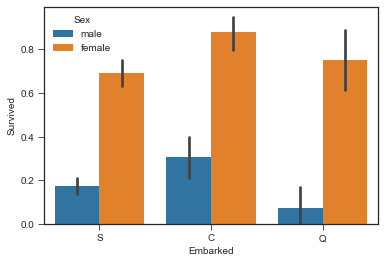

In [8]:
sns.barplot(x="Embarked", y="Survived", hue="Sex", data=data_train);

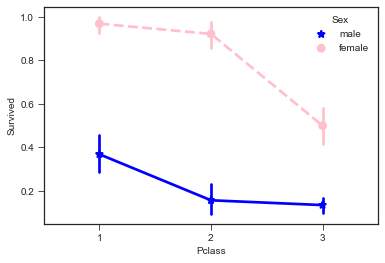

In [9]:
sns.pointplot(x="Pclass", y="Survived", hue="Sex", data=data_train,
              palette={"male": "blue", "female": "pink"},
              markers=["*", "o"], linestyles=["-", "--"]);

In [10]:
data_train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [11]:
data_test.describe()

,PassengerId,Pclass,Age,SibSp,Parch,Fare
count,418.000000,418.000000,332.000000,418.000000,418.000000,417.000000
mean,1100.500000,2.265550,30.272590,0.447368,0.392344,35.627188
std,120.810458,0.841838,14.181209,0.896760,0.981429,55.907576
min,892.000000,1.000000,0.170000,0.000000,0.000000,0.000000
25%,996.250000,1.000000,21.000000,0.000000,0.000000,7.895800
50%,1100.500000,3.000000,27.000000,0.000000,0.000000,14.454200
75%,1204.750000,3.000000,39.000000,1.000000,0.000000,31.500000
max,1309.000000,3.000000,76.000000,8.000000,9.000000,512.329200


In [12]:
pattern_digit = r'[^0-9]'
data_train.Ticket = data_train.Ticket.replace(pattern_digit, ' ',  regex=True)

In [13]:
# data_train.Ticket.split()


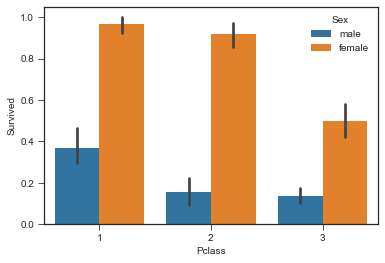

In [14]:
sns.barplot(x="Pclass", y="Survived", hue="Sex", data=data_train);

In [15]:
def simplify_ages(df):
    df.Age = df.Age.fillna(-0.5)
    bins = (-1, 0, 5, 12, 18, 25, 35, 60, 120)
    group_names = ['Unknown', 'Baby', 'Child', 'Teenager', 'Student', 'Young Adult', 'Adult', 'Senior']
    categories = pd.cut(df.Age, bins, labels=group_names)
    df.Age = categories
    return df

def simplify_cabins(df):
    df.Cabin = df.Cabin.fillna('N')
    df.Cabin = df.Cabin.apply(lambda x: x[0])
    return df

def simplify_fares(df):
    df.Fare = df.Fare.fillna(-0.5)
    bins = (-1, 0, 8, 15, 31, 1000)
    group_names = ['Unknown', 'crew', '1st', '2nd', '3rd']
    categories = pd.cut(df.Fare, bins, labels=group_names)
    df.Fare = categories
    return df

def format_name(df):
    df['Lname'] = df.Name.apply(lambda x: x.split(' ')[0])
    df['NamePrefix'] = df.Name.apply(lambda x: x.split(' ')[1])
    return df    
def drop_features(df):
    return df.drop(['Ticket', 'Name', 'Embarked'], axis=1)

def transform_features(df):
    df = simplify_ages(df)
    df = simplify_cabins(df)
    df = simplify_fares(df)
    df = format_name(df)
    df = drop_features(df)
    return df

data_train = transform_features(data_train)
data_test = transform_features(data_test)
data_train.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Lname,NamePrefix
0,1,0,3,male,Student,1,0,crew,N,"Braund,",Mr.
1,2,1,1,female,Adult,1,0,3rd,C,"Cumings,",Mrs.
2,3,1,3,female,Young Adult,0,0,crew,N,"Heikkinen,",Miss.
3,4,1,1,female,Young Adult,1,0,3rd,C,"Futrelle,",Mrs.
4,5,0,3,male,Young Adult,0,0,1st,N,"Allen,",Mr.


In [16]:
data_train.Cabin.unique()

array(['N', 'C', 'E', 'G', 'D', 'A', 'B', 'F', 'T'], dtype=object)

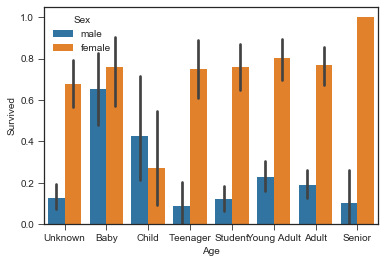

In [17]:
sns.barplot(x="Age", y="Survived", hue="Sex", data=data_train);

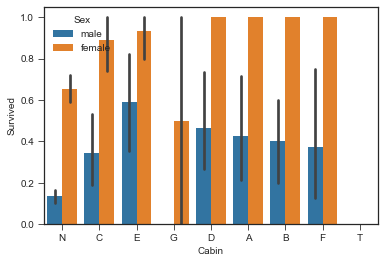

In [18]:
sns.barplot(x="Cabin", y="Survived", hue="Sex", data=data_train);

In [19]:
from sklearn import preprocessing
def encode_features(df_train, df_test):
    features = ['Fare', 'Cabin', 'Age', 'Sex', 'Lname', 'NamePrefix']
    df_combined = pd.concat([df_train[features], df_test[features]])
    
    for feature in features:
        le = preprocessing.LabelEncoder()
        le = le.fit(df_combined[feature])
        df_train[feature] = le.transform(df_train[feature])
        df_test[feature] = le.transform(df_test[feature])
    return df_train, df_test
    
data_train, data_test = encode_features(data_train, data_test)
data_train.head()


,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Lname,NamePrefix
0,1,0,3,1,4,1,0,4,7,100,19
1,2,1,1,0,0,1,0,2,2,182,20
2,3,1,3,0,7,0,0,4,7,329,16
3,4,1,1,0,7,1,0,2,2,267,20
4,5,0,3,1,7,0,0,0,7,15,19


In [20]:
data_test.head()

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Lname,NamePrefix
0,892,3,1,7,0,0,4,7,401,19
1,893,3,0,0,1,0,4,7,843,20
2,894,2,1,3,0,0,0,7,552,19
3,895,3,1,7,0,0,0,7,851,19
4,896,3,0,4,1,1,0,7,342,20


In [21]:
data_test.shape

(418, 10)

In [22]:
from sklearn.model_selection import train_test_split

X_all = data_train.drop(['Survived', 'PassengerId'], axis=1)
y_all = data_train['Survived']
x_test = data_test.drop(['PassengerId'], axis=1)
num_test = 0.20
X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size=num_test, random_state=23)

In [23]:
len(x_test)

418

In [24]:
scalar = StandardScaler()
X_tr= scalar.fit_transform(X_all)
X_te = scalar.transform(x_test)

In [25]:
from sklearn.model_selection import StratifiedKFold

In [149]:
# For an initial search, a logarithmic grid with basis
# 10 is often helpful. Using a basis of 2, a finer
# tuning can be achieved but at a much higher cost.

C_range = 10. ** np.arange(-3, 8)
gamma_range = 10. ** np.arange(-5, 4)

param_grid = dict(gamma=gamma_range, C=C_range)

grid = GridSearchCV(svm.SVC(), param_grid=param_grid, cv=5,n_jobs=-1,verbose=2)



In [150]:
grid.fit(X_tr, y_all)

print("The best classifier is: ", grid.best_estimator_)

Fitting 5 folds for each of 99 candidates, totalling 495 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    3.1s


The best classifier is:  SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.1, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)


[Parallel(n_jobs=-1)]: Done 495 out of 495 | elapsed:  7.8min finished


In [153]:
grid.predict(X_te)

array([0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1,
       1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1,
       1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1,
       0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0,

In [154]:
grid.best_score_

0.813692480359147

In [155]:
ids = data_test['PassengerId']
predictions = clf.predict(data_test.drop('PassengerId', axis=1))


output = pd.DataFrame({ 'PassengerId' : ids, 'Survived': grid.predict(X_te)})
output.to_csv('titanic-smv.csv', index = False)
output.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


In [97]:
svr_poly = svm.SVC()
nfolds = KFold(n_splits=10)

param_grid = {'kernel':['rbf','poly'], 'C':[20 , 30 ,40,50], 'gamma':['auto'] , 'degree':[3,4,5,6] }
grid_search = GridSearchCV(svr_poly,param_grid=param_grid  ,cv=2 ,n_jobs = -1, verbose = 2)
grid_search

GridSearchCV(cv=2, error_score='raise-deprecating',
             estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='auto_deprecated', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='warn', n_jobs=-1,
             param_grid={'C': [20, 30, 40, 50], 'degree': [3, 4, 5, 6],
                         'gamma': ['auto'], 'kernel': ['rbf', 'poly']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=2)

In [98]:
grid_search.get_params().keys()

dict_keys(['cv', 'error_score', 'estimator__C', 'estimator__cache_size', 'estimator__class_weight', 'estimator__coef0', 'estimator__decision_function_shape', 'estimator__degree', 'estimator__gamma', 'estimator__kernel', 'estimator__max_iter', 'estimator__probability', 'estimator__random_state', 'estimator__shrinking', 'estimator__tol', 'estimator__verbose', 'estimator', 'iid', 'n_jobs', 'param_grid', 'pre_dispatch', 'refit', 'return_train_score', 'scoring', 'verbose'])

In [99]:
grid_search.fit(X_train, y_train)


Fitting 2 folds for each of 32 candidates, totalling 64 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


KeyboardInterrupt: 

In [89]:
grid_search.best_score_

0.8237934904601572

In [90]:
grid_search.best_params_

{'C': 20, 'degree': 3, 'gamma': 'auto', 'kernel': 'rbf'}

In [61]:
grid_search.predict(X_te)

array([0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1,
       1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1,
       1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1,
       1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0,
       1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1,
       0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0,

In [63]:
ids = data_test['PassengerId']

output = pd.DataFrame({ 'PassengerId' : ids, 'Survived': grid_search.predict(X_te)})
output.to_csv('titanic-smv_2.csv', index = False)
output.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,0


In [159]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer, accuracy_score,roc_curve,auc,confusion_matrix
from sklearn.model_selection import GridSearchCV

In [81]:


# Choose the type of classifier. 
clf = RandomForestClassifier()

# Choose some parameter combinations to try
parameters = {'n_estimators': [4, 6,7,8 ], 
              'max_features': ['log2', 'sqrt','auto'], 
              'criterion': ['entropy', 'gini'],
              'max_depth': [ 6,9, 10,11], 
              'min_samples_split': [2, 3],
              'min_samples_leaf': [1,5,6,7]
             }

# Type of scoring used to compare parameter combinations
acc_scorer = make_scorer(accuracy_score)

# Run the grid search
grid_obj = GridSearchCV(clf, parameters, scoring=acc_scorer)
grid_obj = grid_obj.fit(X_train, y_train)

# Set the clf to the best combination of parameters
clf = grid_obj.best_estimator_

# Fit the best algorithm to the data. 
clf.fit(X_train, y_train)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
                       max_depth=10, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=3,
                       min_weight_fraction_leaf=0.0, n_estimators=8,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [24]:
predictions = grid_obj.predict(X_test)
print(accuracy_score(y_test, predictions))


0.8044692737430168


In [25]:
predictions

array([1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0,
       1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0,
       1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1,
       0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1,
       1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1,
       1, 0, 1])

In [26]:
ids = data_test['PassengerId']
predictions = clf.predict(data_test.drop('PassengerId', axis=1))


output = pd.DataFrame({ 'PassengerId' : ids, 'Survived': predictions })
# output.to_csv('titanic-predictions.csv', index = False)
output.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1


In [136]:
from sklearn.ensemble import RandomForestClassifier
grid_n_estimator = [10, 50, 100,300]
grid_ratio = [.1, .25, .5, .75, 1.0]
grid_learn = [.01, .03, .05, .1, .25]
grid_max_depth = [2, 4, 6, 8, 10, None]
grid_min_samples = [5, 10, .03, .05, .10]
grid_criterion = [ 'entropy']
grid_bool = [True, False]
grid_seed = [0]
nfolds = KFold(n_splits=10)

#random foreset w/full dataset modeling submission score: defaults= 0.71291, tuned= 0.73205

submit_rfc = GridSearchCV(RandomForestClassifier(),
                                          param_grid={'n_estimators': grid_n_estimator,
                                                      'criterion': grid_criterion, 
                                                      'max_depth': grid_max_depth,
                                                      'random_state': grid_seed}, scoring = 'roc_auc', cv = nfolds)
# submit_rfc.fit(data1[data1_x_bin], data1[Target])
# print('Best Parameters: ', submit_rfc.best_params_) #Best Parameters:  {'criterion': 'entropy', 'max_depth': 6, 
# 'n_estimators': 100, 'random_state': 0}
# data_val['Survived'] = submit_rfc.predict(data_val[data1_x_bin])

In [137]:
submit_rfc.fit(X_tr , y_all)

GridSearchCV(cv=KFold(n_splits=10, random_state=None, shuffle=False),
             error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False,
                                              random_state=None, verbose=0,
                 

In [138]:
submit_rfc.best_score_

0.8763544994769191

In [139]:
submit_rfc.best_params_

{'criterion': 'entropy',
 'max_depth': 8,
 'n_estimators': 300,
 'random_state': 0}

In [140]:
submit_rfc.predict(X_te)

array([0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0,
       1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1,
       1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0,
       1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1,
       0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0,

In [130]:
ids = data_test['PassengerId']
# predictions = clf.predict(data_test.drop('PassengerId', axis=1))


output = pd.DataFrame({ 'PassengerId' : ids, 'Survived': submit_rfc.predict(X_te) })
output.to_csv('titanic-RF.csv', index = False)
output.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1


In [27]:
# output.to_csv('titanic-predictions.csv', index = False)

In [65]:

from sklearn.linear_model import Lasso
from sklearn.ensemble import GradientBoostingClassifier,RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler


In [29]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
import numpy as np 
from scipy import stats
model1 = DecisionTreeClassifier()
model2 = KNeighborsClassifier()
model3= LogisticRegression()

model1.fit(X_train, y_train)
model2.fit(X_train, y_train)
model3.fit(X_train, y_train)

pred1=model1.predict(x_test)
pred2=model2.predict(x_test)
pred3=model3.predict(x_test)

final_pred = np.array([])
for i in range(len(x_test)):
    final_pred = np.append(final_pred, np.mean([pred1[i], pred2[i], pred3[i]]))

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [30]:
len(np.floor(final_pred))

418

In [31]:
# np.round(final_pred).astype(int)

In [32]:
# print(accuracy_score(y_test, final_pred.astype(int)))

In [33]:
ids = data_test['PassengerId']
predictions = clf.predict(data_test.drop('PassengerId', axis=1))


output = pd.DataFrame({ 'PassengerId' : ids, 'Survived': np.floor(final_pred).astype(int)})
# output.to_csv('titanic-predictions.csv', index = False)
output.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0


In [34]:
# output.to_csv('titanic-3models.csv', index = False)

In [35]:
# create models
from sklearn.model_selection import KFold, cross_val_score 

lasso_model = make_pipeline(RobustScaler(), Lasso(alpha=0.0005))
rf = RandomForestClassifier()
gbr = GradientBoostingClassifier()

for model in [lasso_model, rf, gbr]:
     cross_val_score(model,X_train, y_train)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/anaconda3/lib/python3.7/sit

In [36]:
model.fit(X_train, y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='auto',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [37]:
len(np.floor(model.predict(X_test)).astype(int))

179

In [38]:
len(X_test)

179

In [39]:
dt = DecisionTreeClassifier()
rf = RandomForestClassifier()
for model in [dt, rf]:
    cross_val_score(model, X_train, y_train);

/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/anaconda3/lib/python3.7/sit

In [40]:
model.fit(X_train, y_train)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [41]:
len(np.floor(model.predict(x_test)).astype(int))

418

In [42]:
model.score(X_train, y_train)

0.9775280898876404

In [43]:
model.score(X_test, y_test)

0.8044692737430168

In [75]:
print(accuracy_score(y_test, np.floor(model.predict(X_test)).astype(int)))

0.8044692737430168


In [44]:
ids = data_test['PassengerId']
predictions = clf.predict(data_test.drop('PassengerId', axis=1))


output = pd.DataFrame({ 'PassengerId' : ids, 'Survived': np.floor(model.predict(x_test)).astype(int)})
# output.to_csv('titanic-predictions.csv', index = False)
output.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,0


In [45]:
# output.to_csv('titanic_blend.csv', index = False)

In [46]:
from sklearn.model_selection import GridSearchCV

In [64]:
param = { 'max_features': [0.3, 0.6,0.7, 1],
        'n_estimators': [30,20,50 ], 
         'base_estimator__max_depth': [3, 5,4, 6,7,8]}

In [68]:
mdl = BaggingClassifier(base_estimator= DecisionTreeClassifier() , oob_score= True ,n_estimators= 100)
grid = GridSearchCV(mdl,param,cv =10)
grid.fit(X_train,y_train)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/bagging.py:611: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/bagging.py:616: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])
/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/bagging.py:611: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/bagging.py:616: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])
/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/bagging.py:611: UserWarning: Some inputs do not have OOB scores. This pr

GridSearchCV(cv=10, error_score='raise-deprecating',
             estimator=BaggingClassifier(base_estimator=DecisionTreeClassifier(class_weight=None,
                                                                               criterion='gini',
                                                                               max_depth=None,
                                                                               max_features=None,
                                                                               max_leaf_nodes=None,
                                                                               min_impurity_decrease=0.0,
                                                                               min_impurity_split=None,
                                                                               min_samples_leaf=1,
                                                                               min_samples_split=2,
                                                  

In [66]:
grid.best_params_

{'base_estimator__max_depth': 7, 'max_features': 0.6, 'n_estimators': 30}

In [67]:
grid.best_score_

0.8370786516853933

In [53]:
ids = data_test['PassengerId']
predictions = clf.predict(data_test.drop('PassengerId', axis=1))


output = pd.DataFrame({ 'PassengerId' : ids, 'Survived': np.floor(grid.predict(x_test)).astype(int)})
# output.to_csv('titanic-predictions.csv', index = False)
output.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


In [54]:
output.to_csv('titanic-BaggingClassifier.csv', index = False)

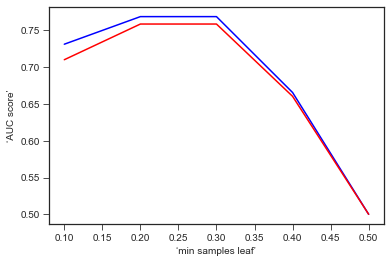

In [183]:
min_samples_leafs = np.linspace(0.1, 0.5, 5, endpoint=True)
train_results = []
test_results = []
per =[]
for min_samples_leaf in min_samples_leafs:
       dt = DecisionTreeClassifier(min_samples_leaf=min_samples_leaf)
       dt.fit(X_train, y_train)
       train_pred = dt.predict(X_train)
       false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
       roc_auc = auc(false_positive_rate, true_positive_rate)
       train_results.append(roc_auc)
       y_pred = dt.predict(X_test)
       d = dt.predict(x_test)
       false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
       roc_auc = auc(false_positive_rate, true_positive_rate)
       test_results.append(roc_auc)
       per.append(d)
from matplotlib.legend_handler import HandlerLine2D
line1 = plt.plot(min_samples_leafs, train_results,'b', label='”Train AUC”')
line2 = plt.plot(min_samples_leafs, test_results, 'r', label='”Test AUC”')

plt.ylabel('‘AUC score’')
plt.xlabel('‘min samples leaf’')
plt.show()

In [112]:
test_pred

array([1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0,
       1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1,
       1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1,
       1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0,
       1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0,

In [117]:
dt.score(X_train, y_train)

0.8904494382022472

In [118]:
dt.score(X_test, y_test)

0.7932960893854749

In [201]:
len(y_all.loc[len(X_te)-1:])

474

In [125]:
param = { 'max_features': [0.3,0.5, 0.6, 1],
        'n_estimators': [50,100, 150, 200], 
         'base_estimator__max_depth': [2,3, 5, 20]}

mdl = BaggingClassifier(base_estimator= DecisionTreeClassifier() , oob_score= True ,n_estimators= 50)
grid = GridSearchCV(mdl,param,cv =10)
grid.fit(X_train,y_train)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=10, error_score='raise-deprecating',
             estimator=BaggingClassifier(base_estimator=DecisionTreeClassifier(class_weight=None,
                                                                               criterion='gini',
                                                                               max_depth=None,
                                                                               max_features=None,
                                                                               max_leaf_nodes=None,
                                                                               min_impurity_decrease=0.0,
                                                                               min_impurity_split=None,
                                                                               min_samples_leaf=1,
                                                                               min_samples_split=2,
                                                  

In [128]:
grid.best_score_

0.8342696629213483

In [126]:
grid.best_params_

{'base_estimator__max_depth': 5, 'max_features': 0.6, 'n_estimators': 100}

In [127]:
grid.predict(x_test)

array([0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0,
       1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1,
       1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1,
       1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1,
       0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0,

In [130]:
ids = data_test['PassengerId']
predictions = clf.predict(data_test.drop('PassengerId', axis=1))


output = pd.DataFrame({ 'PassengerId' : ids, 'Survived':grid.predict(x_test) })
output.to_csv('titanic_bagDT.csv', index = False)
output.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1


In [142]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report


In [151]:
#List Hyperparameters that we want to tune.
leaf_size = list(range(1,50))
n_neighbors = list(range(1,30))
p=[1,2]
#Convert to dictionary
hyperparameters = dict(leaf_size=leaf_size, n_neighbors=n_neighbors, p=p)
#Create new KNN object
knn_2 = KNeighborsClassifier()
#Use GridSearch
clf = GridSearchCV(knn_2, hyperparameters, cv=10,n_jobs=-1,verbose=2)
#Fit the model
best_model = clf.fit(X_train,y_train)
#Print The value of best Hyperparameters
print('Best leaf_size:', best_model.best_estimator_.get_params()['leaf_size'])
print('Best p:', best_model.best_estimator_.get_params()['p'])
print('Best n_neighbors:', best_model.best_estimator_.get_params()['n_neighbors'])

Fitting 10 folds for each of 2842 candidates, totalling 28420 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done 825 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done 3667 tasks      | elapsed:    7.3s
[Parallel(n_jobs=-1)]: Done 7629 tasks      | elapsed:   11.2s
[Parallel(n_jobs=-1)]: Done 12739 tasks      | elapsed:   15.6s
[Parallel(n_jobs=-1)]: Done 18969 tasks      | elapsed:   21.3s
[Parallel(n_jobs=-1)]: Done 26347 tasks      | elapsed:   28.4s


Best leaf_size: 21
Best p: 1
Best n_neighbors: 5


[Parallel(n_jobs=-1)]: Done 28420 out of 28420 | elapsed:   30.6s finished
/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [152]:
clf.predict(x_test)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0,
       1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0,
       0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0,
       0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0,
       1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0,
       1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0,

In [154]:
clf.score(X_test,y_test)

0.6927374301675978

In [148]:
ids = data_test['PassengerId']
predictions = clf.predict(data_test.drop('PassengerId', axis=1))


output = pd.DataFrame({ 'PassengerId' : ids, 'Survived':clf.predict(X_te) })
output.to_csv('titanic_knn.csv', index = False)
output.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1


In [211]:
lr_list = [0.01,0.05, 0.075, 0.1, 0.25, 0.5, 0.75, 1,1.5]

for learning_rate in lr_list:
    gb_clf = GradientBoostingClassifier(n_estimators=20, learning_rate=learning_rate, max_features=2, max_depth=2, random_state=0)
    gb_clf.fit(X_train, y_train)

    print("Learning rate: ", learning_rate)
    print("Accuracy score (training): {0:.3f}".format(gb_clf.score(X_tr, y_all)))
    print("Accuracy score (validation): {0:.3f}".format(gb_clf.score(X_te, y_all.loc[:len(X_te)-1])))

Learning rate:  0.01
Accuracy score (training): 0.616
Accuracy score (validation): 0.610
Learning rate:  0.05
Accuracy score (training): 0.787
Accuracy score (validation): 0.505
Learning rate:  0.075
Accuracy score (training): 0.409
Accuracy score (validation): 0.400
Learning rate:  0.1
Accuracy score (training): 0.407
Accuracy score (validation): 0.402
Learning rate:  0.25
Accuracy score (training): 0.403
Accuracy score (validation): 0.400
Learning rate:  0.5
Accuracy score (training): 0.738
Accuracy score (validation): 0.555
Learning rate:  0.75
Accuracy score (training): 0.618
Accuracy score (validation): 0.612
Learning rate:  1
Accuracy score (training): 0.617
Accuracy score (validation): 0.615
Learning rate:  1.5
Accuracy score (training): 0.501
Accuracy score (validation): 0.579


In [209]:
gb_clf2 = GradientBoostingClassifier(n_estimators=50, learning_rate=.5, max_features=2, max_depth=2, random_state=0)
gb_clf2.fit(X_tr, y_all)
predictions = gb_clf2.predict(X_te)



In [210]:
gb_clf2.score(X_te, y_all.loc[:len(X_te)-1])

0.49282296650717705

In [197]:
gb_clf2.score(X_tr, y_all)

0.8720538720538721

In [182]:
gb_clf2.score(X_train, y_train)

0.6095505617977528

In [215]:
from xgboost import XGBClassifier

model = XGBClassifier()

In [231]:
model.fit(X_tr, y_all)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [232]:
model.score(X_tr, y_all)

0.8832772166105499

In [233]:
model.score(X_te, y_all.loc[:len(X_te)-1])

0.5143540669856459

In [234]:
model.predict(X_te)

array([0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1,
       1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1,
       0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0,
       1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1,
       0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0,

In [224]:
ids = data_test['PassengerId']
predictions = clf.predict(data_test.drop('PassengerId', axis=1))


output = pd.DataFrame({ 'PassengerId' : ids, 'Survived':model.predict(x_test) })
output.to_csv('titanic_xgb.csv', index = False)
output.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,0


In [229]:

# split data into train and test sets

# fit model no training data
model = XGBClassifier()
model.fit(X_train, y_train)
# make predictions for test data
y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]
# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
accuracy

0.8324022346368715

In [230]:
y_pred

array([1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1,
       1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0,
       1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0,
       1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1,
       0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1,
       1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1,
       1, 1, 1])